In [1]:
%matplotlib notebook
import astropy.table as table
import numpy as np
import matplotlib.pyplot as plt
import observesim.robot
import fitsio
import numpy.random as random

## Coverage dependence

This notebook tests the dependence of completeness and efficiency of targeting objects as a function of the density of targets and the density of tiles (== observations), for a fiber robot such as that in SDSS-V.

In this document, by "completeness" I mean "what fraction of the desired targets got fibers". By "efficiency" I mean "what fraction of fibers get used." Not everyone uses these same definitions so beware!

The robot consists of fiber positioners in a hex array, each one with an annular coverage. We do not account for realistic positioner collisions. For this analysis, we use fiber positions from a design provided by the OSU group. We only consider the actuators with APOGEE fibers. 

The targets are distributed as a Poisson distribution.

We assign fibers to each observation using a simple greedy algorithm, encoded in the Robot class. It simply cycles through the positioners, finds the targets it can reach, and grabs a random one from it. In this notebook, we call this multiple times to build up all the observations of a field.

Note that this method is not optimal. Finding the optimal solution of this problem is tractable, and not terribly difficult, but my intuition from previous work is that it will only improve efficiencies by a few percent and I don't expect it will perturb the qualitative conclusions here.

I have assumed here the APO plate scale, but this only affects the normalization of the densities, which should scale as the ratio of the focal ratios squared: $(7.45/5)^2$.

Finally, I haven't distinguished between different types of targets, most particularly not between science and calibration stars.

<IPython.core.display.Javascript object>


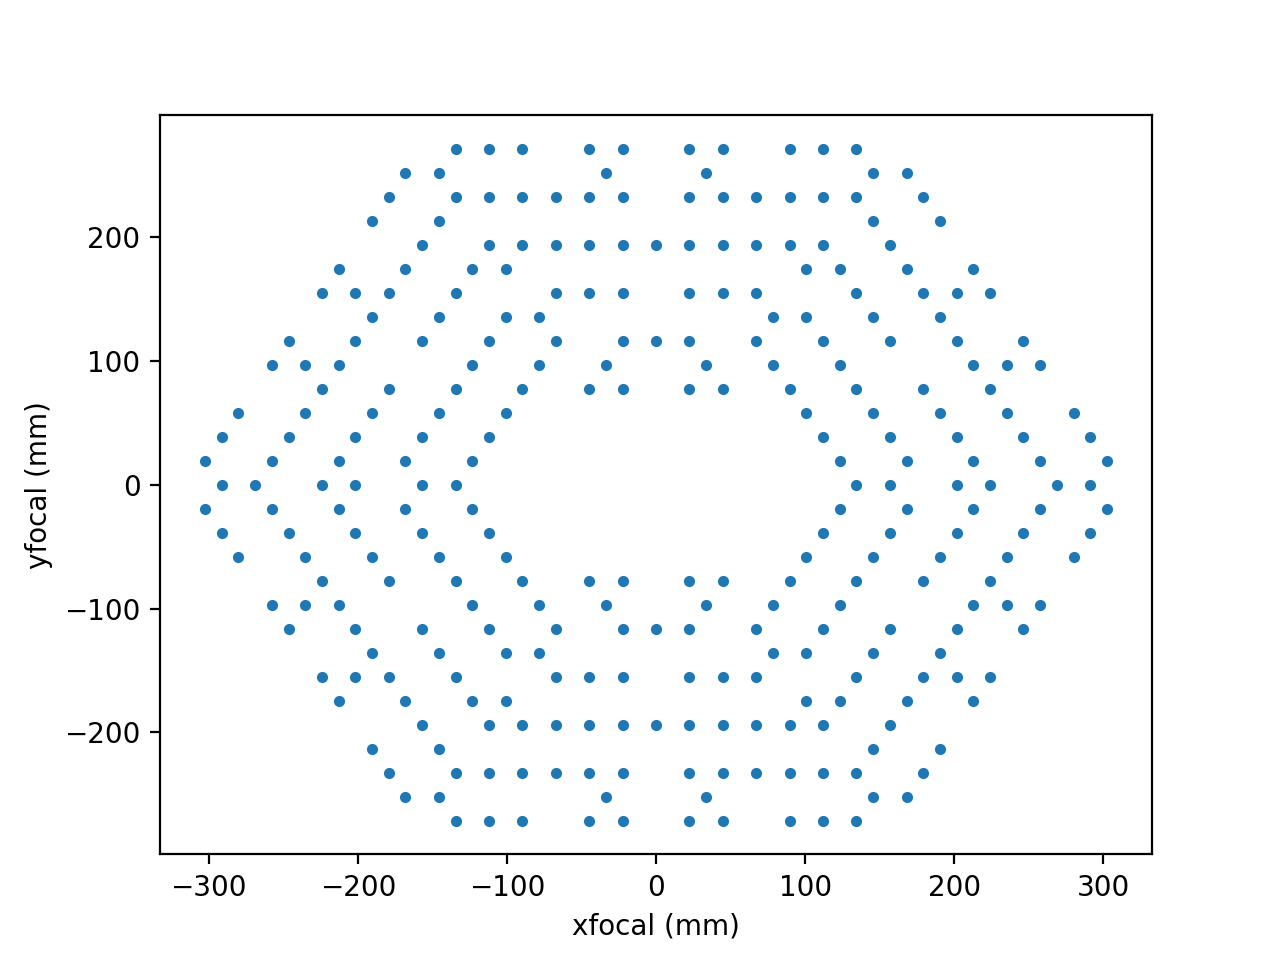

Text(0,0.5,'yfocal (mm)')

In [2]:
robot = observesim.robot.Robot()
iapogee = np.where(robot.apogee)[0]
plt.plot(robot.xcen[iapogee], robot.ycen[iapogee], '.')
plt.xlabel('xfocal (mm)')
plt.ylabel('yfocal (mm)')

This piece of code does the assignment for a given number of targets and a number of observations (called tiles here).

In [3]:
def analyze_random(ntarget, ntile):
    """Analyze a particular number of targets and tiles
    
    Parameters:
    ----------
    
    ntarget : int, np.int32
        number of targets in test
    
    ntile : int, np.int32
        number of observations in test
        
    Returns:
    -------
    
    dtargets : np.float32
        density of targets (per deg^2)
    
    dtiles : np.float32
        density of targets (per deg^2)
        
    dgot : np.float32
        density of targets getting fibers (per deg^2)
        
    ncovered : np.int32
        number of targets in test actually covered by actuators
        
    ngot : np.int32
        number of targets that get fibers 
        
    Comments:
    --------
    
    Assumes APO plate scale. Densities should all scale to LCO based 
    on focal ratio differences as (7.45/5)^2.
    
    Hard-codes area covered by actuators as 5.4 deg^2 (used for dgot)
    
    """
    dmax = 350.
    scale = 218.  # mm /deg
    xtarget = dmax * (random.random(ntarget) * 2. - 1.)
    ytarget = dmax * (random.random(ntarget) * 2. - 1.)
    dtargets = np.float32(ntarget) / (4. * dmax**2 / scale**2)  # in targets / deg^2
    dtiles = np.float32(ntile) / 5.4  # in targets / deg^2
    covered = robot.covered(xtarget, ytarget, 'apogee')
    positionerids = np.zeros(ntarget, dtype=np.int32) - 1
    tileids = np.zeros(ntarget, dtype=np.int32) - 1
    for itile in np.arange(ntile):
        inotgot = np.where(positionerids == -1)[0]
        (newpositionerids, targets) = robot.assign(xtarget[inotgot],
                                                   ytarget[inotgot], 'apogee') 
        igot = np.where(newpositionerids >= 0)[0]
        positionerids[inotgot[igot]] = newpositionerids[igot]
        tileids[inotgot[igot]] = itile + 1
    ncovered = len(np.where(covered > 0)[0])
    ngot = len(np.where(positionerids >= 0)[0])
    dgot = np.float32(ngot) / 5.4
    return(dtargets, dtiles, dgot, ncovered, ngot)

## Results

We call this for a range of tiles (1 .. 10) and numbers of targets (which will correspond to target densities). We calculate the fraction of targets observed, the fraction of fibers used, and the density of targets gotten. This assumes that the number of APOGEE fibers is 300.

In [4]:
ntiles = (1 + np.arange(10))
ntargets = 500 * (1 + np.arange(20))
fused = np.zeros((len(ntiles), len(ntargets)))
fgot = np.zeros((len(ntiles), len(ntargets)))
dgot = np.zeros((len(ntiles), len(ntargets)))
dtargets = np.zeros(len(ntargets))
dtiles = np.zeros(len(ntiles))
for itile in np.arange(len(ntiles)):
    ntile = ntiles[itile]
    for itarget in np.arange(len(ntargets)):
        ntarget = ntargets[itarget]
        # print("ntile = {ntile} ; ntarget = {ntarget}".format(ntile=ntile, ntarget=ntarget))
        (tmp_dtargets, tmp_dtiles, tmp_dgot,
         tmp_ncovered, tmp_ngot) = analyze_random(ntarget, ntile)
        dtargets[itarget] = tmp_dtargets
        dtiles[itile] = tmp_dtiles
        dgot[itile, itarget] = tmp_dgot
        fused[itile, itarget] = np.float32(tmp_ngot) / 300. / np.float(ntile)
        fgot[itile, itarget] = np.float32(tmp_ngot) / np.float32(tmp_ncovered)

In [5]:
dtarget_low = dtargets[0] - 0.5 * (dtargets[1] - dtargets[0])
dtarget_high = dtargets[-1] + 0.5 * (dtargets[1] - dtargets[0])
dtile_low = dtiles[0] - 0.5 * (dtiles[1] - dtiles[0])
dtile_high = dtiles[-1] + 0.5 * (dtiles[1] - dtiles[0])
extent = [dtarget_low, dtarget_high, dtile_low, dtile_high]

### Fraction of fibers used

We plot the fraction of fibers used as a function of the target density and tile density. The tile density just corresponds to covering the field some number of times.

As you expect, at a given target density, you use most of the fibers for a small number of tiles, and fewer and fewer if you cover the field more (since in this model you only observe each object once).

<IPython.core.display.Javascript object>


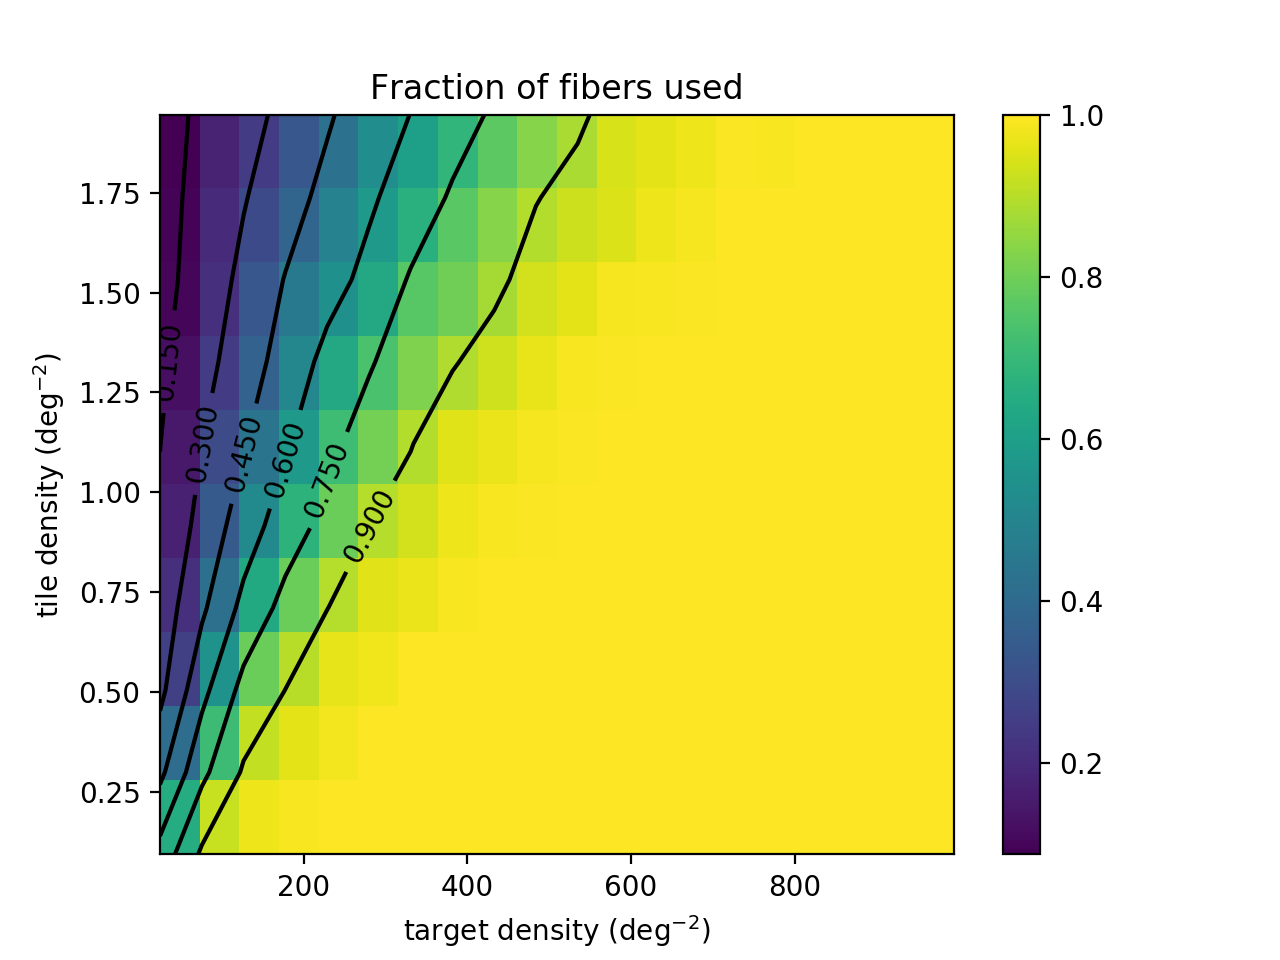

Text(0,0.5,'tile density (deg$^{-2}$)')

In [6]:
plt.imshow(fused, origin='lower', extent=extent, interpolation='nearest', aspect='auto')
plt.title('Fraction of fibers used')
plt.colorbar()
CS = plt.contour(fused, extent=extent, aspect='auto', colors='black')
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('target density (deg$^{-2}$)')
plt.ylabel('tile density (deg$^{-2}$)')

### Fraction of targets observed

We plot the fraction of targets observed as a function of the target density and tile density. The tile density just corresponds to covering the field some number of times.

As you expect, at a given target density, you observe a larger fraction of targets for a larger number of tiles.

<IPython.core.display.Javascript object>


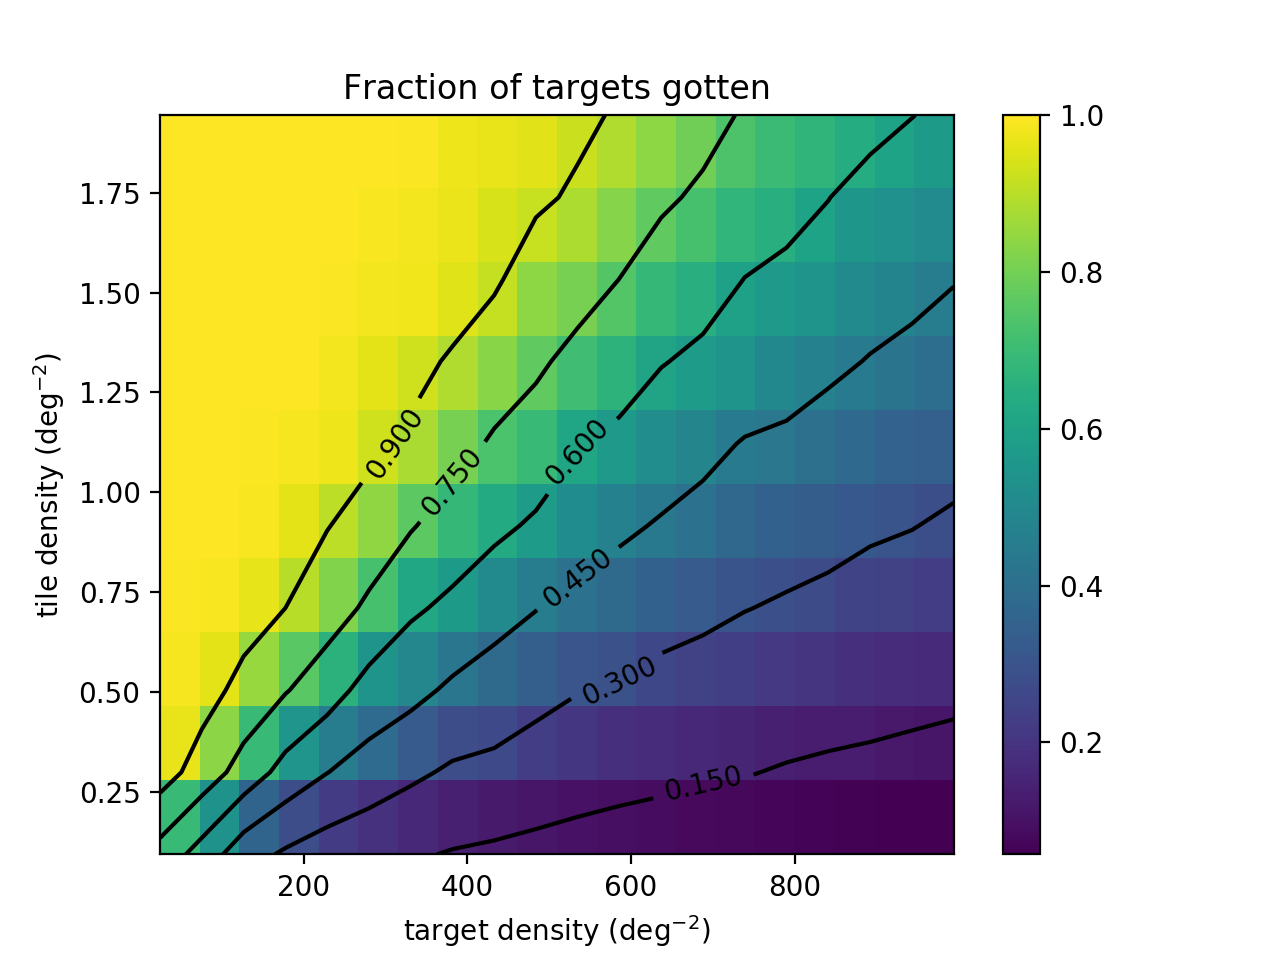

Text(0,0.5,'tile density (deg$^{-2}$)')

In [7]:
plt.imshow(fgot, origin='lower', extent=extent, interpolation='nearest', aspect='auto')
plt.title('Fraction of targets gotten')
plt.colorbar()
CS = plt.contour(fgot, extent=extent, aspect='auto', colors='black')
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('target density (deg$^{-2}$)')
plt.ylabel('tile density (deg$^{-2}$)')

### Density of targets gotten

You can also calculate the density of targets that you get as a function of target and tile density. This is an interesting quantity because it is pretty much the thing you want to maximize. 

As you might expect, it increases with tile density, but with diminishing returns (when the contours become vertical).

<IPython.core.display.Javascript object>


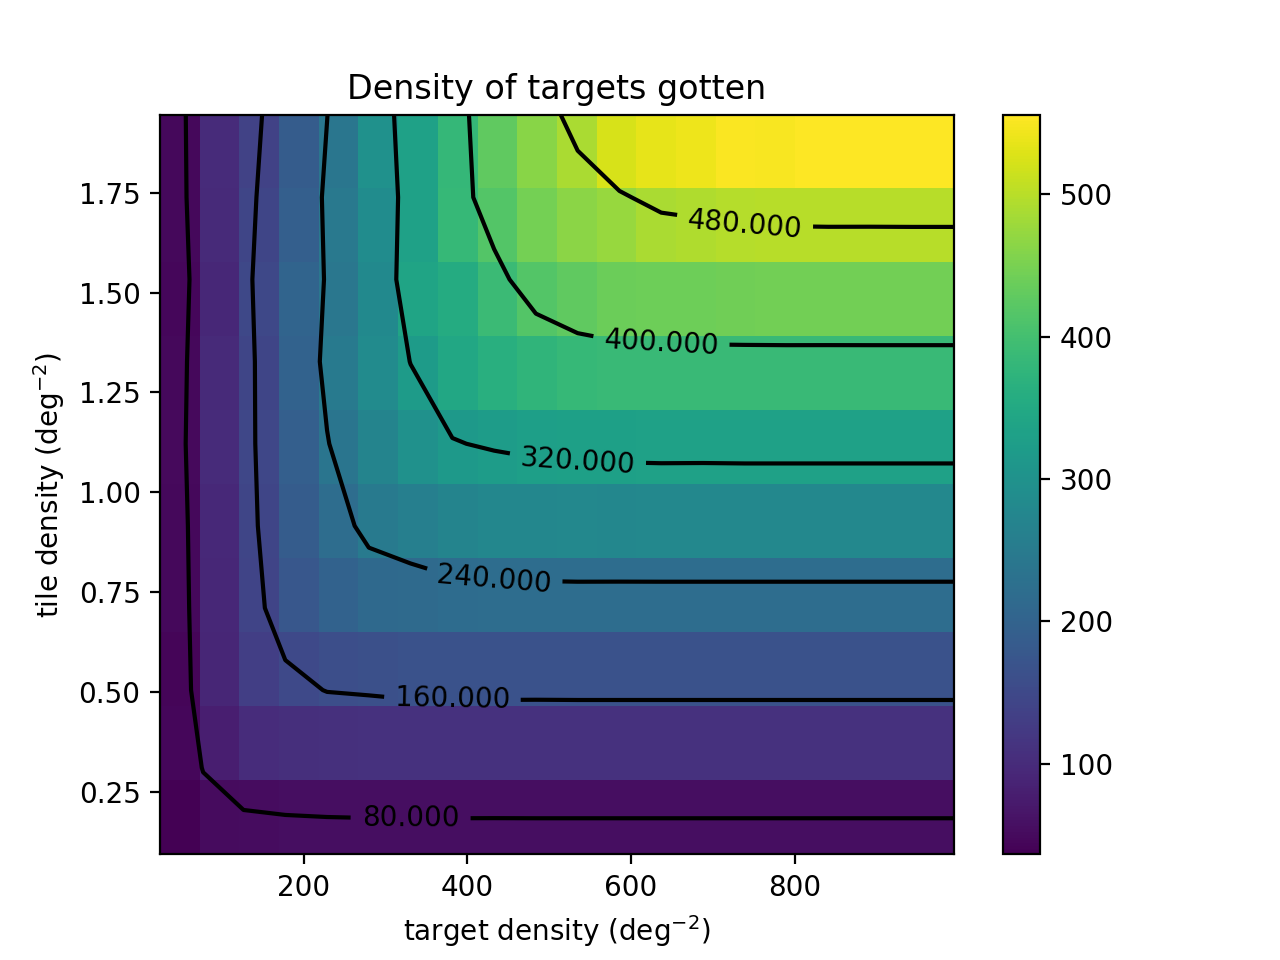

Text(0,0.5,'tile density (deg$^{-2}$)')

In [8]:
plt.imshow(dgot, origin='lower', extent=extent, interpolation='nearest', aspect='auto')
plt.title('Density of targets gotten')
plt.colorbar()
plt.ylabel('number deg$^{-2]$')
CS = plt.contour(dgot, extent=extent, aspect='auto', colors='black')
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('target density (deg$^{-2}$)')
plt.ylabel('tile density (deg$^{-2}$)')

### Confusing but revealing overlapping plot of results.

We can overlap on the previous plot the contours of the fraction of fibers used (yellow) and fraction of targets observed (white). This plot reveal the "sweet spot" at any given target density, where these fractions are about the same. 

You can see that this sweet spot corresponds to fraction of between 0.8 and 0.9 and that as you might guess lies near the "corner" in the density of targets gotten. Interestingly, it really is helpful to have a high density of targets, which is where the sweet spot is about 0.9.

My use of the term "sweet spot" is clearly loaded --- you might at high density much prefer efficiency to completeness! In which case you would use a number of tiles somewhat below the sweet spot.

<IPython.core.display.Javascript object>


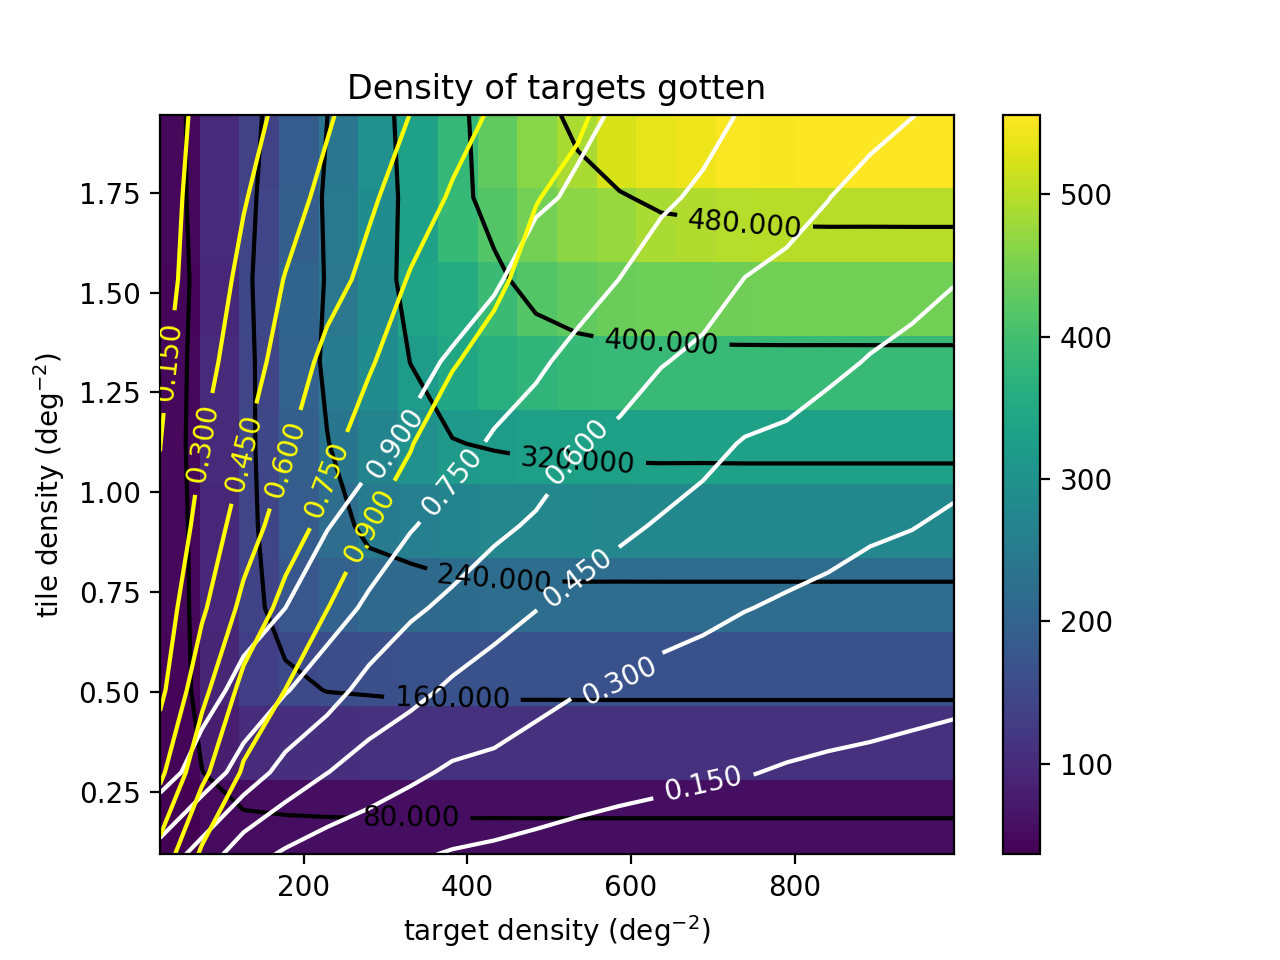

Text(0,0.5,'tile density (deg$^{-2}$)')

In [9]:
plt.imshow(dgot, origin='lower', extent=extent, interpolation='nearest', aspect='auto')
plt.title('Density of targets gotten')
plt.colorbar()
plt.ylabel('number deg$^{-2]$')
CS = plt.contour(dgot, extent=extent, aspect='auto', colors='black')
plt.clabel(CS, inline=1, fontsize=10)
CS = plt.contour(fgot, extent=extent, aspect='auto', colors='white')
plt.clabel(CS, inline=1, fontsize=10)
CS = plt.contour(fused, extent=extent, aspect='auto', colors='yellow')
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('target density (deg$^{-2}$)')
plt.ylabel('tile density (deg$^{-2}$)')

### 1-D plots, slicing through these plots

It may be easier to understand the plots if we slice through them at fixed target density, and just ask about the fraction of fibers used and fraction of targets gotten as a function of the number of tiles observed. I show this plot for several target densities.

It shows the same thing that the above plots show, namely that the fractions cross at about 0.8. It is very close to true that this sweet spot is achieved with a number of observations that makes the density of targets equal to the density of fibers (this has to be the case for my definition of sweet spot, if you think about it).

In [10]:
def plot_ff(indx):
    plt.plot(ntiles, fused[:, indx], label='fraction fibers used')
    plt.plot(ntiles, fgot[:, indx], label='fraction targets gotten')
    plt.title('target density of {dt} per deg$^2$, {dt2} per tile area, {n:0.2f} tiles-worth'
              .format(dt=np.int32(dtargets[indx]), dt2=np.int32(dtargets[indx] * 5.4),
                      n=dtargets[indx] * 5.4 / 300))
    plt.xlabel('Number of observations')
    plt.legend()

<IPython.core.display.Javascript object>


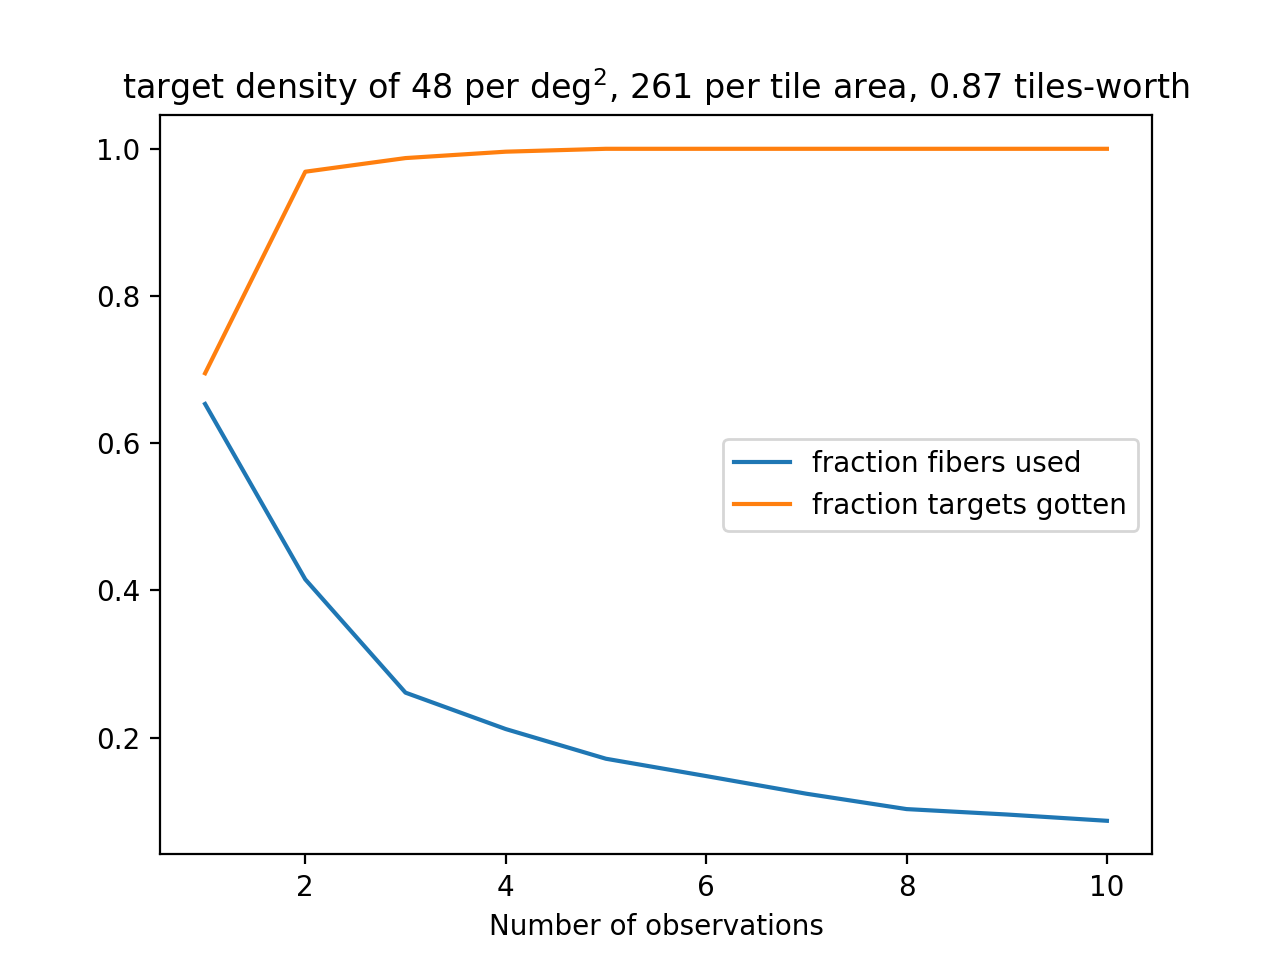

In [11]:
plot_ff(0)

<IPython.core.display.Javascript object>


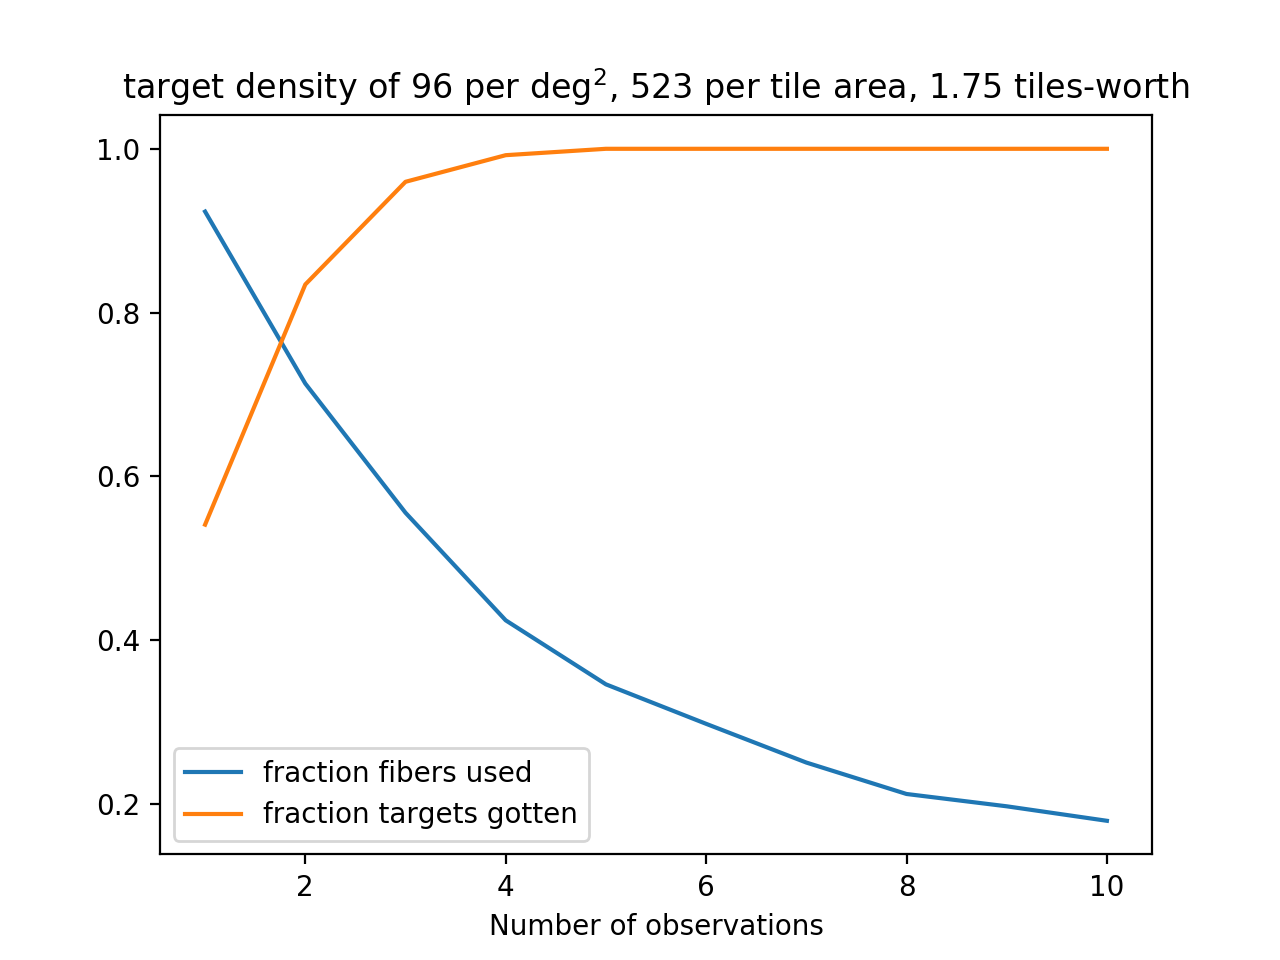

In [12]:
plot_ff(1)

<IPython.core.display.Javascript object>


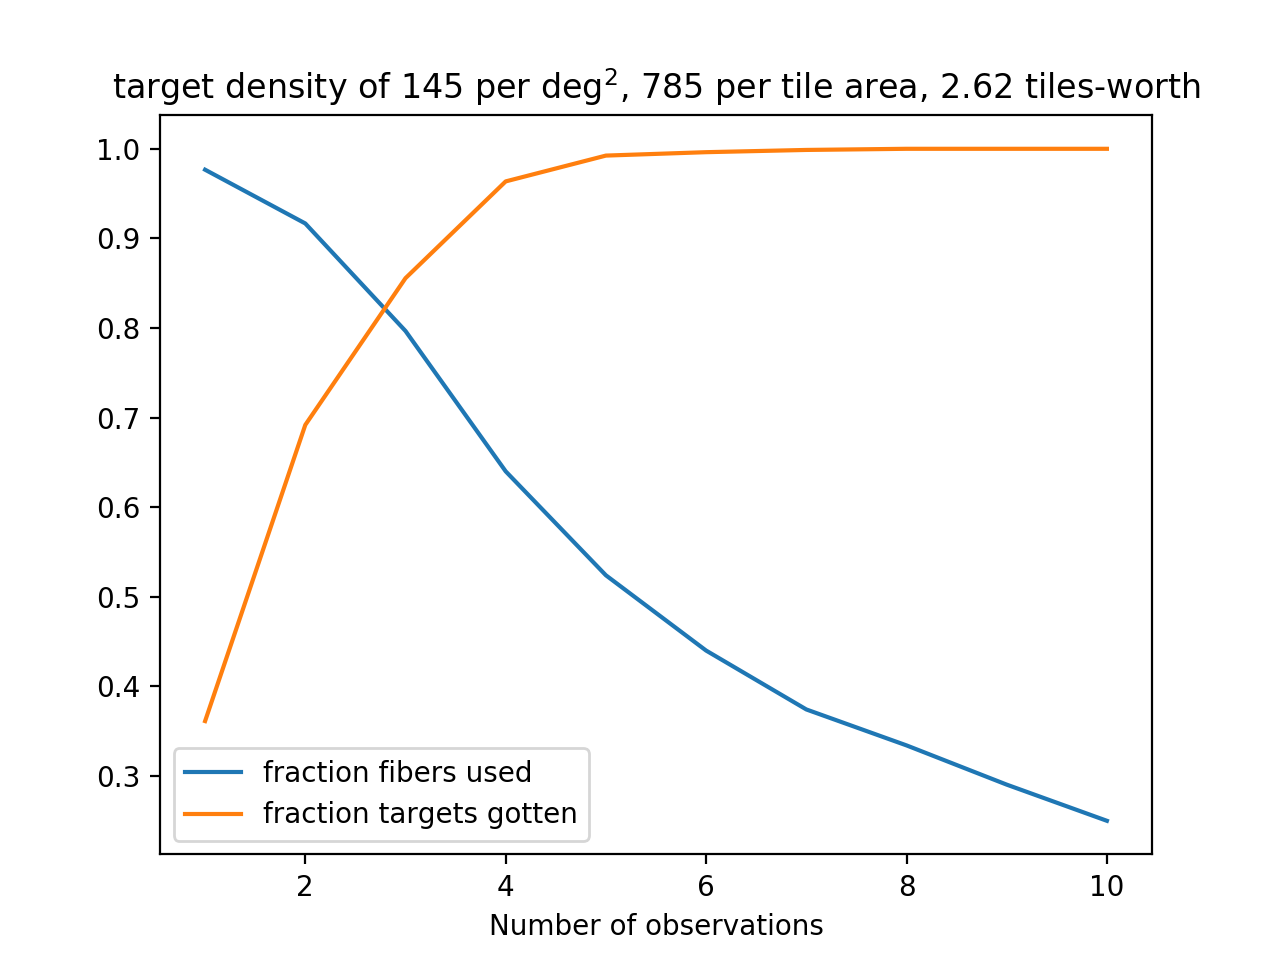

In [13]:
plot_ff(2)

<IPython.core.display.Javascript object>


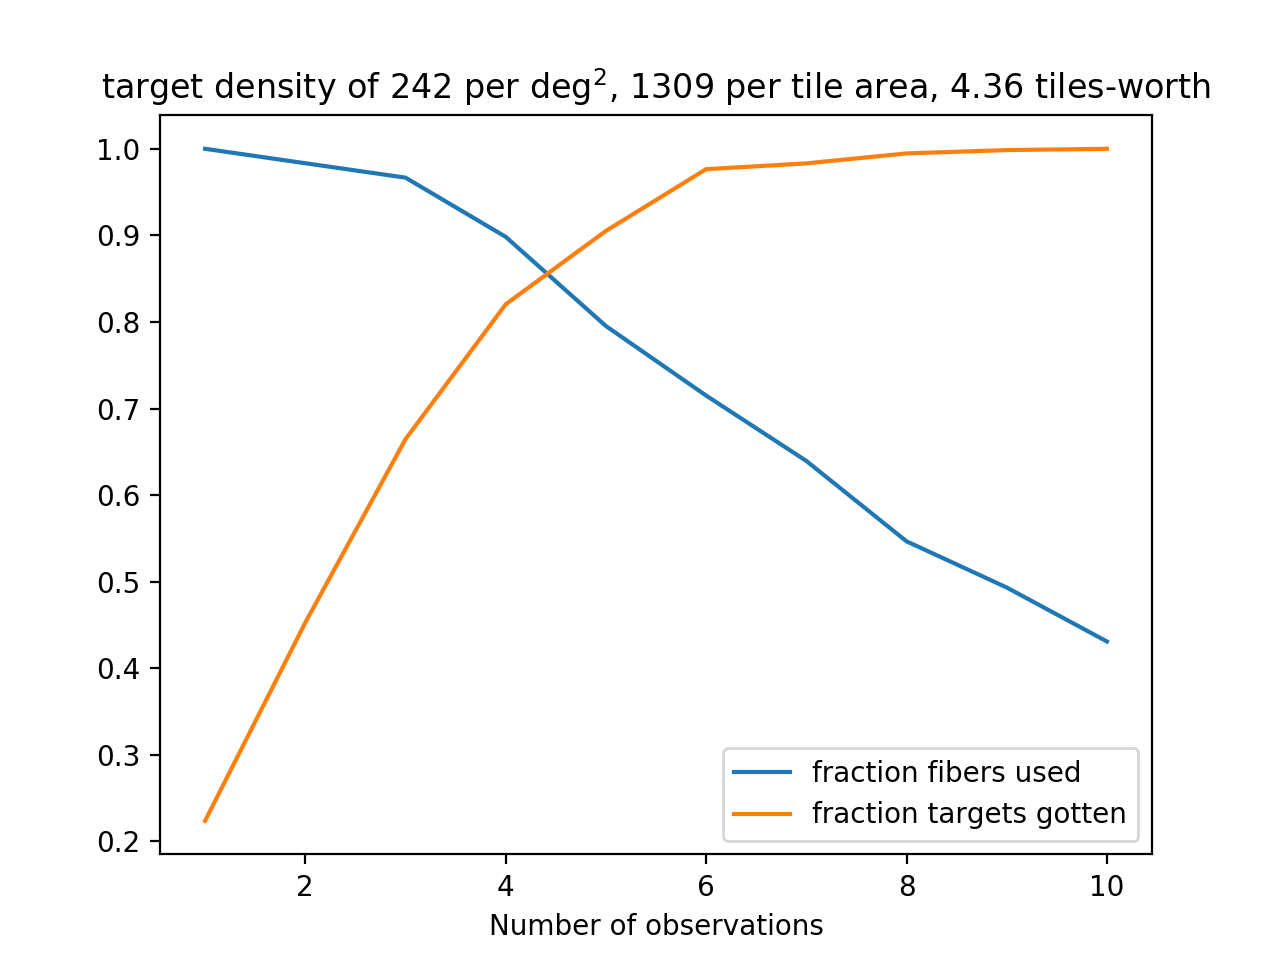

In [14]:
plot_ff(4)

<IPython.core.display.Javascript object>


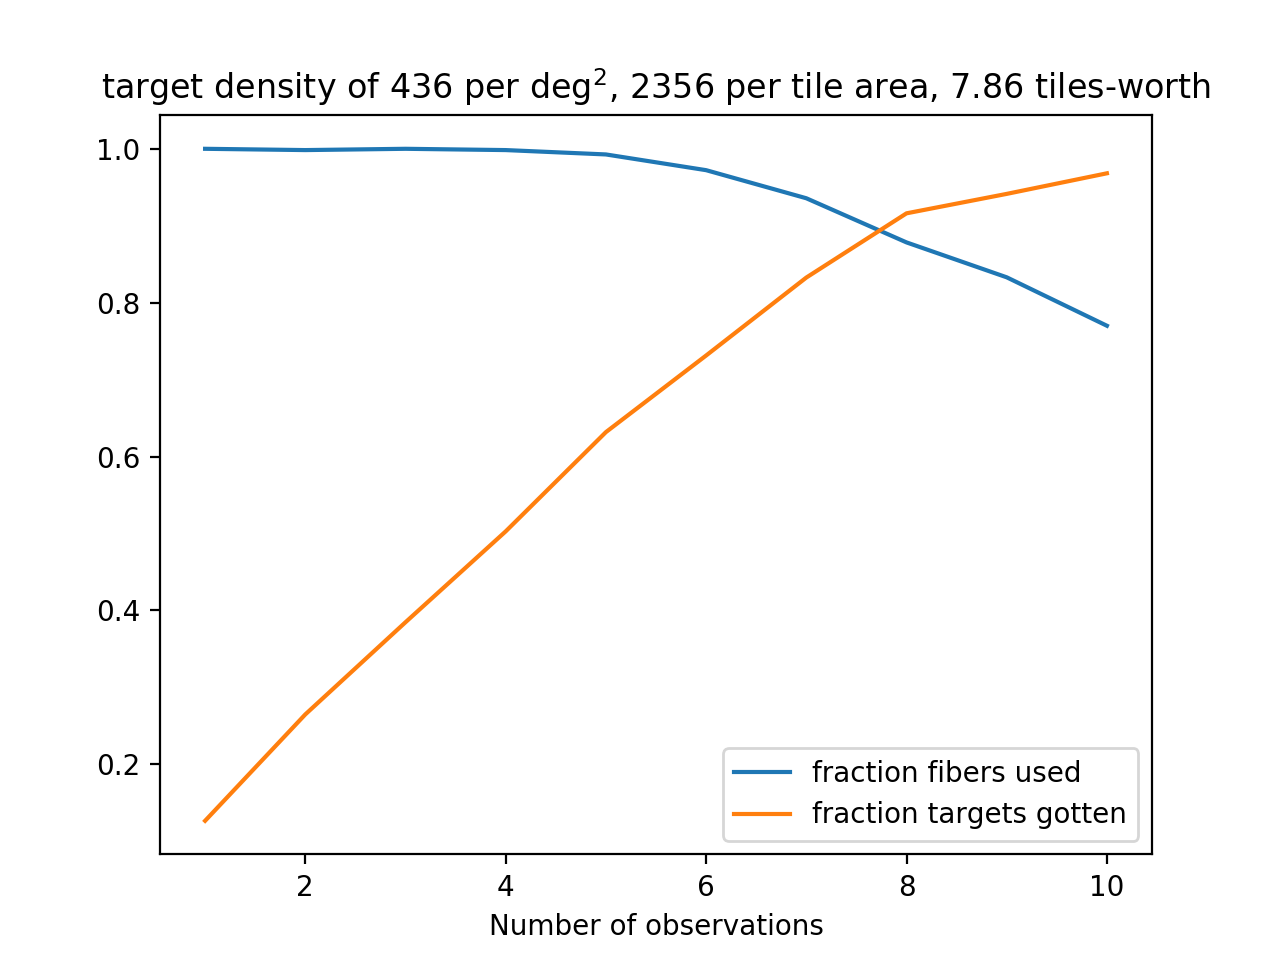

In [15]:
plot_ff(8)

## Notes on code

This code depends primarily on the latest version of observesim. 

The Robot() class in that code right now reads the robot configuration from a file checked into observesim. targetdb does not yet have all the relevant information. In particular, it needs to have added:

 * optical : is there an optical fiber (0 or 1)
 * apogee : is there an APOGEE fiber (0 or 1)
 
I will note that the configuration file also has ROW and POS, which might be good to have in the db too.